In [4]:
import sys
import cv2
import rbcompiler.api_v2 as rb
import pyRbRuntime as rt
import numpy as np
import sg.dcn 

import torch
from yolact import Yolact
from data import set_cfg
from utils.augmentations import FastBaseTransform
import matplotlib.pyplot as plt
from eval import prep_display

In [5]:
%matplotlib inline

In [2]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
set_cfg('yolact_plus_resnet50_config')
net = Yolact()
net.load_weights('weights/yolact_plus_resnet50_54_800000.pth')
net.eval()

In [3]:
# run torch  
img_path = './data/3.jpg'
img_1 = torch.from_numpy(cv2.imread(img_path)).cuda().float()
img = FastBaseTransform()(img_1.unsqueeze(0))
print(img.shape)
preds = net(img)
out = net.detect(preds, net)

torch.Size([1, 3, 550, 550])


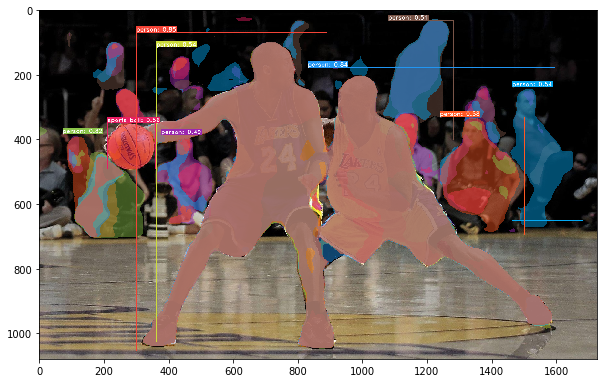

In [6]:
img_numpy = prep_display(out, img_1, None, None, undo_transform=False)
img_numpy = img_numpy[:, :, (2, 1, 0)]
plt.figure(figsize=(10,10))
plt.imshow(img_numpy)
plt.show()

In [7]:
# # run runtime
rb_net = rt.Network('./sg/yolact_plus.sg', dp=[rt.GPU])
outputs = rb_net.Run(img.cpu().detach().numpy().astype(np.float32))
preds['loc'] = torch.from_numpy(outputs['1995']).cuda().float()
preds['conf'] = torch.from_numpy(outputs['2005']).cuda().float()
preds['mask'] = torch.from_numpy(outputs['2001']).cuda().float()
out = net.detect(preds, net)
img_numpy = prep_display(out, img_1, None, None, undo_transform=False)

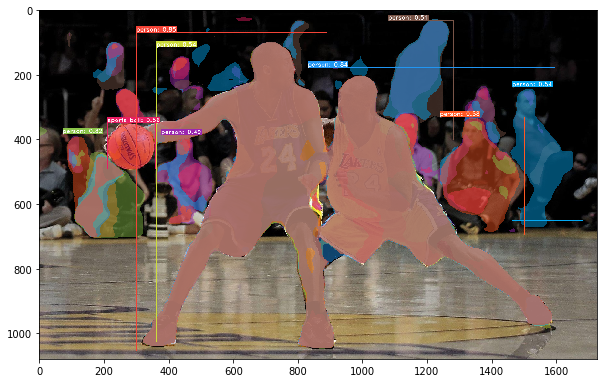

In [8]:
img_numpy = img_numpy[:, :, (2, 1, 0)]
plt.figure(figsize=(10,10))
plt.imshow(img_numpy)
plt.show()